In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.client import device_lib
#check if gpu available
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# gpu memory
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

['/device:CPU:0', '/device:GPU:0']


# Load dataset

In [2]:
from tensorflow.keras.utils import to_categorical  

#load cifar-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
#one hot encoding
y_test=to_categorical(y_test, num_classes=10)
y_train=to_categorical(y_train, num_classes=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


### Validation data

In [3]:
#shuffle data and split data to generate validation data
shuffler = np.random.permutation(len(x_train))
x_train = x_train[shuffler]
y_train = y_train[shuffler]
 

#validation data
x_val=x_train[0:2000]
y_val=y_train[0:2000]

x_train=x_train[2000:]
y_train=y_train[2000:]


In [4]:
batch_size=10
epochs=3
base_learning_rate=0.0001

# InceptionV3

![image](./figures/inceptionv3.png)

In [5]:
inception_v3_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True, weights=None, classes=10, input_shape=(150,150,3)
)

In [65]:
help(tf.keras.applications.inception_v3.InceptionV3)

Help on function InceptionV3 in module tensorflow.python.keras.applications.inception_v3:

InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')
    Instantiates the Inception v3 architecture.
    
    Reference:
    - [Rethinking the Inception Architecture for Computer Vision](
        http://arxiv.org/abs/1512.00567) (CVPR 2016)
    
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in the `tf.keras.backend.image_data_format()`.
    
    Note: each Keras Application expects a specific kind of input preprocessing.
    For InceptionV3, call `tf.keras.applications.inception_v3.preprocess_input`
    on your inputs before passing them to the model.
    
    Arguments:
      include_top: Boolean, whether to include the fully-connected
        layer at the top, as the last layer of the network. Default to `True`

In [82]:
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_852 (Conv2D)             (None, 49, 49, 32)   864         input_20[0][0]                   
__________________________________________________________________________________________________
batch_normalization_846 (BatchN (None, 49, 49, 32)   96          conv2d_852[0][0]                 
__________________________________________________________________________________________________
activation_846 (Activation)     (None, 49, 49, 32)   0           batch_normalization_846[0][0]    
_______________________________________________________________________________________

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

inception_v3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])

train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=4, #+-4 pixel shift max
        height_shift_range=4,#+-4 pixel shift max
        cval=0, #zero padding
        fill_mode='constant' #zero padding
        )

# train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
# step_size_train=train_generator.n//train_generator.batch_size

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.InceptionV3.re
x = inception_v3_model(x)
x=GlobalAveragePooling2D()(x)
preds=Dense(10,activation='softmax')(x)
inception_v3_model_cifar10=Model(inputs=inputs,outputs=preds)
inception_v3_model_cifar10.summary()

ValueError: Layer inception_v3 expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=32>, <tf.Tensor: shape=(), dtype=int32, numpy=32>, <tf.Tensor: shape=(), dtype=int32, numpy=3>]

Size of CIFAR (32x32) is incompatible with InceptionV3, if we fed this input to the first convolutional layers in InceptionV3, we'd end up with no pixels at the end (because of the max pooling operations). We resize the input to 299x299.

In [8]:
x_train_reshaped = tf.image.resize(x_train, (150,150))

x_val_reshaped =  tf.image.resize(x_val, (150,150))

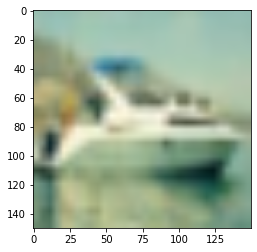

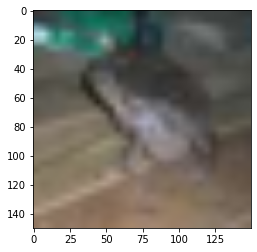

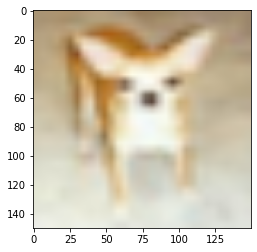

In [9]:
plt.imshow(x_train_reshaped[0]/255)
plt.show()
plt.imshow(x_train_reshaped[1]/255)
plt.show()
plt.imshow(x_train_reshaped[2]/255)
plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

inception_v3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])

train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=4, #+-4 pixel shift max
        height_shift_range=4,#+-4 pixel shift max
        cval=0, #zero padding
        fill_mode='constant' #zero padding
        )

# train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
# step_size_train=train_generator.n//train_generator.batch_size



# x_train= x_train[:5000]
# y_train= y_train[:5000]


history=inception_v3_model.fit(x=x_train_reshaped, y=y_train,
                   epochs = 30,
                   validation_data=(x_val_reshaped, y_val))

Epoch 1/30
1500/1500 [==============================] - 84s 49ms/step - loss: 1.8070 - acc: 0.3443 - val_loss: 1.4444 - val_acc: 0.5190
Epoch 2/30
1500/1500 [==============================] - 71s 47ms/step - loss: 1.2845 - acc: 0.5398 - val_loss: 1.2511 - val_acc: 0.5610
Epoch 3/30
1500/1500 [==============================] - 71s 47ms/step - loss: 1.0237 - acc: 0.6405 - val_loss: 1.0792 - val_acc: 0.6420
Epoch 4/30
1500/1500 [==============================] - 71s 47ms/step - loss: 0.8167 - acc: 0.7131 - val_loss: 0.9351 - val_acc: 0.6720
Epoch 5/30
1500/1500 [==============================] - 71s 47ms/step - loss: 0.6537 - acc: 0.7734 - val_loss: 0.8725 - val_acc: 0.7105
Epoch 6/30
1500/1500 [==============================] - 71s 47ms/step - loss: 0.5172 - acc: 0.8224 - val_loss: 0.7810 - val_acc: 0.7370
Epoch 7/30
1500/1500 [==============================] - 71s 47ms/step - loss: 0.4124 - acc: 0.8575 - val_loss: 0.7160 - val_acc: 0.7690
Epoch 8/30
1500/1500 [==========================

KeyboardInterrupt: 

# Adding SE layers

### This is what we had before: normal resnet50

In [33]:
keras.utils.plot_model(inception_v3_model, to_file='inception_v3_model.png',show_shapes=True)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [31]:
import pydot

### List of layers where SE is going to be added after the output

(Check resnet50.png for more information)

In [ ]:
l=[l.name for l in resnet50.layers]
list_se=[]
for i,name in enumerate(l):
    if(i+1<len(l) and 'add' in l[i+1]):
        print(name)
        list_se.append(name)


In [ ]:
###### Not used #######
#custom SE Layer (not working)
from tensorflow.python.keras.layers import GlobalAveragePooling2D
class SE_layer(tf.keras.layers.Layer):
    def __init__(self, ratio=16,initializer="he_normal", **kwargs):
        super(SE_layer, self).__init__(**kwargs)
        self.initializer = keras.initializers.get(initializer)
        self.ratio=ratio

    def build(self, input_shape):
        out_dim = input_shape[-1]
    def call(self, inputs): 
        print(inputs.shape[-1])
        out_dim=inputs.shape[-1]
        F_sq = GlobalAveragePooling2D()(inputs) #squeeze
        F_ex = Dense(out_dim / self.ratio,activation='relu')(F_sq)
        F_ex = Dense(out_dim,activation='sigmoid')(F_ex)
        F_ex = tf.reshape(F_ex, [-1,1,1,out_dim])
        F_scale = inputs * F_ex
        return F_scale

    def get_config(self):
        # Implement get_config to enable serialization.
        base_config = super(SE_layer, self).get_config()
        config = {"initializer": keras.initializers.serialize(self.initializer)}
        return dict(list(base_config.items()) + list(config.items()))

### Adding SE layers before 'add' layers

In [ ]:
####### add SE layers to model ##########
# input: model
#        l: list l of layer names where SE layers are going to go after
#        ratio : SE ratio
#        modelname: name of new model
#
# Output: modified model with SE layers at specified locations
# See https://stackoverflow.com/questions/49492255/how-to-replace-or-insert-intermediate-layer-in-keras-model to understand the function
##########################################

def add_SE(model, l,ratio,modelname=None):
    se_num =1
    # Auxiliary dictionary to describe the network graph
    network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    model_outputs = []
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert SE layers if name matches the argument list
        if layer.name in l:
            #input of SE
            x = layer(layer_input)
            
            ### adding SE layers
            out_dim=layer.output_shape[-1]
            #squeeze layer
            F_sq = GlobalAveragePooling2D(name='SE'+str(se_num)+'_global_avg')(x) #squeeze
            #Excitation with 2 fully connected layers
            F_ex = Dense(out_dim / ratio,activation='relu', name='SE'+str(se_num)+'_dense_relu')(F_sq)
            F_ex = Dense(out_dim,activation='sigmoid', name='SE'+str(se_num)+'_dense_sig')(F_ex)
            #Output : rescaling
            F_ex = tf.reshape(F_ex, [-1,1,1,out_dim])
            x=keras.layers.multiply([x,F_ex], name='SE'+str(se_num)+'_scaling')
            
            se_num+=1 # for naming
            print('added SE after ',layer.name)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

        # Renaming model
        if layer.name in model.output_names:
            model_outputs.append(x)
        my_final_model= Model(inputs=model.inputs, outputs=model_outputs)
        if (modelname!=None):
            my_final_model._name = modelname
        else:
            my_final_model._name='SE_'+model._name
    return my_final_model

SE_ResNet50 = ResNet50(include_top=False, weights=None)
def SE_factory(ratio):
    return SE_layer(ratio=ratio)

SE_ResNet50 = add_SE(SE_ResNet50, list_se,ratio=16)
#SE_ResNet50.save('temp.h5')
#SE_ResNet50 = keras.models.load_model('temp.h5',custom_objects={'SE_layer': SE_layer})
SE_ResNet50.summary()
keras.utils.plot_model(SE_ResNet50, to_file='test.png',show_shapes=True)

### Adding topo layer, and input preprocessing (different resolution)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D

inputs = tf.keras.Input(shape=(32, 32, 3))
# Preprocess for ResNet50 input size
x = preprocess_input(inputs)
# ResNet50
x = SE_ResNet50(x)
# Add top layer again
x=GlobalAveragePooling2D()(x)
#10 classes for cifar 10
preds=Dense(10,activation='softmax')(x)
SE_resnet50_cifar10=Model(inputs=inputs,outputs=preds)
SE_resnet50_cifar10.summary()


# Todo : train model with custom loop, adaptive learning rate, saving model every k epochs etc

# Top n accuracy

In [ ]:
def top_n_acc(pred, targets,n=1):
    acc=np.mean(tf.keras.metrics.top_k_categorical_accuracy(targets, pred, k=n).numpy())
    print("top",n,'accuracy:',acc,sep=' ')
    return acc

In [ ]:
preds=resnet50_cifar10.predict(x_test)
top_n_acc(preds,y_test,1)

# Recreating Inception model

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPool2D, Activation, BatchNormalization

def Conv2D_Stack(input, filters, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu') :
    #A Conv2D layer followed by a Batch normalization and an activation
    input_shape = tf.shape(input)
    output = Conv2D(filters=filters, kernel_size= kernel_size, strides = strides, padding = padding, input_shape=input_shape[1:])(input)
    output = BatchNormalization()(output)
    output = Activation(activation)(output)
    return output

In [3]:
#TODO: Inception Block A
def block_A(input, number = 1):
    #number = number of the block A in inception (in total: 3 blocks)

    filters_branch_4 = 64 - (number == 1) * 32 #32 filters for first block A, 64 for the others

    branch_1 = Conv2D_Stack(input, filters = 64, kernel_size = (1,1), activation = 'relu')

    branch_2 = Conv2D_Stack(input, filters = 48, kernel_size = (1,1), activation = 'relu')
    branch_2 = Conv2D_Stack(branch_2, filters = 64, kernel_size = (5,5), activation = 'relu')

    branch_3 = Conv2D_Stack(input, filters = 64 , kernel_size = (1,1), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 96, kernel_size = (3,3), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 96, kernel_size = (3,3), activation = 'relu')

    branch_4 = AvgPool2D(pool_size = (3,3), strides = (1,1), padding = 'same')(input)
    branch_4 = Conv2D_Stack(branch_4, filters = filters_branch_4, kernel_size = (1,1), activation = 'relu')

    output = tf.concat(axis=3, values=[branch_1, branch_2, branch_3, branch_4])
    
    return output

In [4]:
#TODO: Inception Block B
#Note: At each use of Block B, Tensorflow implementaton might take values slightly different for the kernel
#size, I might take that into consideration later on

def block_B(input, number = 1):

    filters_inter = (number == 1) * 128 + (number in (2,3) ) * 160 + (number == 4) * 192 #Intermediate Conv2D layers of first block B have 128 filters, then 160, 160, 192 for 2nd, 3rd and 4th instance of block B

    branch_1 = Conv2D_Stack(input, filters = 192, kernel_size = (1,1), activation = 'relu')

    branch_2 = AvgPool2D(pool_size = (3,3), strides = (1,1), padding = 'same')(input)
    branch_2 = Conv2D_Stack(branch_2, filters = 192, kernel_size = (1,1), activation = 'relu')

    branch_3 = Conv2D_Stack(input, filters = filters_inter, kernel_size = (1,1), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = filters_inter, kernel_size = (1,7), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 192, kernel_size = (7,1), activation = 'relu')

    branch_4 = Conv2D_Stack(input, filters = filters_inter , kernel_size = (1,1), activation = 'relu')
    branch_4 = Conv2D_Stack(branch_4, filters = filters_inter, kernel_size = (7,1), activation = 'relu')
    branch_4 = Conv2D_Stack(branch_4, filters = filters_inter, kernel_size = (1,7), activation = 'relu')
    branch_4 = Conv2D_Stack(branch_4, filters = filters_inter, kernel_size = (7,1), activation = 'relu')
    branch_4 = Conv2D_Stack(branch_4, filters = 192, kernel_size = (1,7), activation = 'relu')

    output = tf.concat(axis=3, values=[branch_1, branch_2, branch_3, branch_4])
    
    return output

In [5]:
#TODO: Inception Block C
def block_C(input):
    #block_C is called 2 times in incetpion, with the exact same parameters

    branch_1 = Conv2D_Stack(input, filters = 320, kernel_size = (1,1), activation = 'relu')

    branch_2 = Conv2D_Stack(input, filters = 384, kernel_size = (1,1), activation = 'relu')
    branch_2_a = Conv2D_Stack(branch_2, filters = 384, kernel_size = (1,3), activation = 'relu')
    branch_2_b = Conv2D_Stack(branch_2, filters = 384, kernel_size = (3,1), activation = 'relu')

    branch_3 = Conv2D_Stack(input, filters = 448 , kernel_size = (1,1), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 384, kernel_size = (3,3), activation = 'relu')
    branch_3_a = Conv2D_Stack(branch_3, filters = 384, kernel_size = (3,1), activation = 'relu')
    branch_3_b = Conv2D_Stack(branch_3, filters = 384, kernel_size = (1,3), activation = 'relu')

    branch_4 = AvgPool2D(pool_size = (3,3), strides = (1,1), padding = 'same')(input)
    branch_4 = Conv2D_Stack(branch_4, filters = 192, kernel_size = (1,1), activation = 'relu')

    output = tf.concat(axis=3, values=[branch_1, branch_2_a, branch_2_b, branch_3_a, branch_3_b, branch_4])

    return output

In [6]:
#TODO: Inception Reduction A
def reduction_block_A(input):
    branch_1 = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(input)

    branch_2 = Conv2D_Stack(input, kernel_size = (3,3), filters = 384, strides = 2, padding = 'valid', activation = 'relu')

    branch_3 = Conv2D_Stack(input, filters = 64, kernel_size = (1,1), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 96, kernel_size = (3,3), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 96, kernel_size = (3,3), strides = 2, padding = 'valid', activation = 'relu')

    output = tf.concat(axis=3, values=[branch_1, branch_2, branch_3])

    return output

In [7]:
#TODO: Inception Reduction B
def reduction_block_B(input):
    branch_1 = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(input)

    branch_2 = Conv2D_Stack(input, kernel_size = (1,1), filters = 192, activation = 'relu')
    branch_2 = Conv2D_Stack(branch_2, kernel_size = (3,3), filters = 320, strides = 2, padding = 'valid', activation = 'relu')

    branch_3 = Conv2D_Stack(input, filters = 192, kernel_size = (1,1), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 192, kernel_size = (1,7), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 192, kernel_size = (7,1), activation = 'relu')
    branch_3 = Conv2D_Stack(branch_3, filters = 192, kernel_size = (3,3), strides = 2, padding = 'valid', activation = 'relu')

    output = tf.concat(axis=3, values=[branch_1, branch_2, branch_3])

    return output

In [9]:
#TODO: Inception forward
input = tf.keras.layers.Input(shape = (299, 299, 3))
n_classes = 10

x = Conv2D_Stack(input, kernel_size = (3,3), filters = 32, strides = 2, padding = 'valid', activation = 'relu')
x = Conv2D_Stack(x, kernel_size = (3,3), filters = 32, strides = 1, padding = 'valid', activation = 'relu')
x = Conv2D_Stack(x, kernel_size = (3,3), filters = 64, strides = 1, padding = 'valid', activation = 'relu')

x = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(x)

x = Conv2D_Stack(x, kernel_size = (1,1), filters = 80, strides = 1, padding = 'valid', activation = 'relu')

x = Conv2D_Stack(x, kernel_size = (3,3), filters = 192, strides = 1, padding = 'valid', activation = 'relu')

x = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(x)

x = block_A(x, number = 1)
x = block_A(x, number = 2)
x = block_A(x, number = 3)

x = reduction_block_A(x)

x = block_B(x, number = 1)
x = block_B(x, number = 2)
x = block_B(x, number = 3)
x = block_B(x, number = 4)

x = reduction_block_B(x)
x = block_C(x_test)
x = block_C(x)

x = GlobalAveragePooling2D(x)
tf.shape(x)

NameError: name 'x_test' is not defined

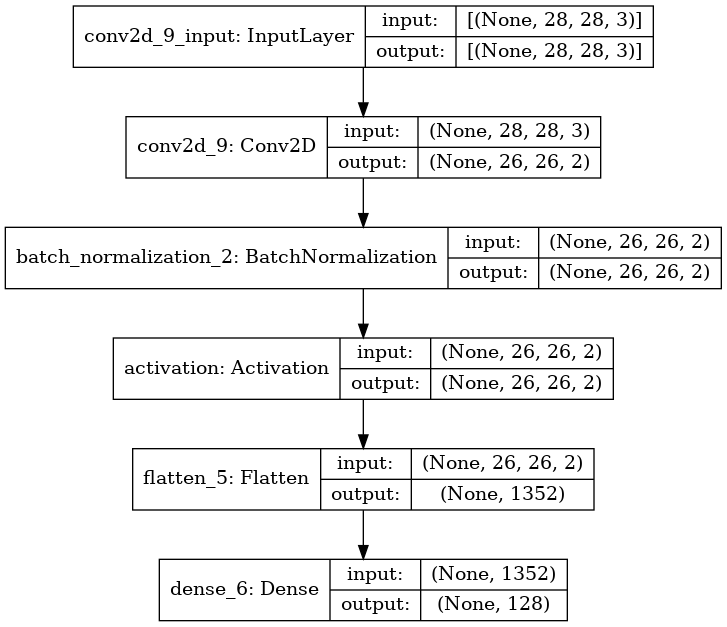

In [29]:
input_shape = (4, 8, 8, 1280)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv2D(2, 3, input_shape=input_shape[1:])(x)
print(y.shape)
(4, 26, 26, 2)

(4, 6, 6, 2)


(4, 26, 26, 2)